In [1]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/\(데이콘\)운동동작분류/data ./

## Load Data

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('./data/train_features.csv')
train_x = df.values[:,2:].reshape(-1,600,6)
print(train_x.shape)
# df

df = pd.read_csv('./data/train_labels.csv')
train_y = df.values[:,1].astype(np.int)
print(train_y.shape)
# df

(3125, 600, 6)
(3125,)


In [3]:
# column 6 -> 8

train_x[:,:,3:] /= 100
acc_std = np.std(train_x[:,:,:3], axis=-1).reshape(-1, 600, 1)
gy_std = np.std(train_x[:,:,3:], axis=-1).reshape(-1, 600, 1)
train_x = np.concatenate([train_x, acc_std, gy_std], axis=-1)
print(train_x.shape)

(3125, 600, 8)


## Show Data

In [4]:
import matplotlib.pyplot as plt

def show_data(x, label):
  print(label)
  data = x
  fig = plt.figure(figsize=(14,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax1.plot(data[:,0], label='acc_x')
  ax1.plot(data[:,1], label='acc_y')
  ax1.plot(data[:,2], label='acc_z')
  ax1.grid()
  ax1.legend()
  ax2.plot(data[:,3], label='gy_x')
  ax2.plot(data[:,4], label='gy_y')
  ax2.plot(data[:,5], label='gy_z')
  ax2.grid()
  ax2.legend()

  plt.show()

## Split Data

In [5]:
from sklearn.model_selection import train_test_split

part_x, valid_x, part_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=666)
print(part_x.shape)
print(part_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(2812, 600, 8)
(2812,)
(313, 600, 8)
(313,)


## DA Method1 - "Rotation"

In [6]:
temp1 = part_x[:,:,[1,2,0,3,5,6,4,7]]
temp2 = part_x[:,:,[2,0,1,3,6,4,5,7]]
new_part_x = np.concatenate([part_x, temp1, temp2], axis=0)
print(new_part_x.shape)

temp1 = valid_x[:,:,[1,2,0,3,5,6,4,7]]
temp2 = valid_x[:,:,[2,0,1,3,6,4,5,7]]
new_valid_x = np.concatenate([valid_x, temp1, temp2], axis=0)
print(new_valid_x.shape)

(8436, 600, 8)
(939, 600, 8)


## DA Method2 - "Permutation"

In [7]:
def DA_permutation(X, num_perm=4, noise_range=30):
  X_new = np.zeros(X.shape)
  idx = np.random.permutation(num_perm)
  segs = np.linspace(0,X.shape[0], num_perm+1)
  segs[1:-1] += np.random.randint(-noise_range, noise_range, size=len(segs[1:-1]))
  segs = segs.astype(int)

  pp = 0
  for ii in range(num_perm):
    x_temp = X[segs[idx[ii]]:segs[idx[ii]+1], :]
    X_new[pp:pp+len(x_temp), :] = x_temp
    pp += len(x_temp)

  return X_new

In [8]:
temp1 = np.zeros(new_part_x.shape)
temp2 = np.zeros(new_part_x.shape)
for i in range(len(new_part_x)):
  temp1[i,:,:] = DA_permutation(new_part_x[i])
  temp2[i,:,:] = DA_permutation(new_part_x[i])
new_part_x = np.concatenate([new_part_x, temp1, temp2], axis=0)
print(new_part_x.shape)

temp1 = np.zeros(new_valid_x.shape)
temp2 = np.zeros(new_valid_x.shape)
for i in range(len(new_valid_x)):
  temp1[i,:,:] = DA_permutation(new_valid_x[i])
  temp2[i,:,:] = DA_permutation(new_valid_x[i])
new_valid_x = np.concatenate([new_valid_x, temp1, temp2], axis=0)
print(new_valid_x.shape)

(25308, 600, 8)
(2817, 600, 8)


## DA Method3 - "Noise"

In [9]:
def DA_noise(X, win=3):
  idx = np.arange(X.shape[0])
  for i in range(len(idx) - win):
    np.random.shuffle(idx[i:i+win])
  return X[idx, :]

In [10]:
temp1 = np.zeros(new_part_x.shape)
temp2 = np.zeros(new_part_x.shape)
for i in range(len(new_part_x)):
  temp1[i,:,:] = DA_noise(new_part_x[i])
  temp2[i,:,:] = DA_noise(new_part_x[i])
new_part_x = np.concatenate([new_part_x, temp1, temp2], axis=0)
print(new_part_x.shape)

temp1 = np.zeros(new_valid_x.shape)
temp2 = np.zeros(new_valid_x.shape)
for i in range(len(new_valid_x)):
  temp1[i,:,:] = DA_noise(new_valid_x[i])
  temp2[i,:,:] = DA_noise(new_valid_x[i])
new_valid_x = np.concatenate([new_valid_x, temp1, temp2], axis=0)
print(new_valid_x.shape)

(75924, 600, 8)
(8451, 600, 8)


## DA final

In [11]:
times = len(new_part_x) // len(part_y)
new_part_y = np.concatenate([part_y]*times, axis=0)
print(new_part_y.shape)

times = len(new_valid_x) // len(valid_y)
new_valid_y = np.concatenate([valid_y]*times, axis=0)
print(new_valid_y.shape)

(75924,)
(8451,)


In [12]:
new_train_x = np.concatenate([new_part_x, new_valid_x], axis=0)
new_train_y = np.concatenate([new_part_y, new_valid_y], axis=0)

idx = np.arange(len(new_train_y))
np.random.shuffle(idx)

new_train_x = new_train_x[idx]
new_train_y = new_train_y[idx]

print(new_train_x.shape)
print(new_train_y.shape)

(84375, 600, 8)
(84375,)


## Model

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, MaxPool1D, SeparableConv1D, AvgPool1D, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Flatten, Activation, Dropout, BatchNormalization, Input, Add, GlobalAvgPool1D, Subtract, Reshape, Concatenate, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

def conv1d_bn(x, filters, kernel_size, padding='same', strides=1, activation='elu', weight_decay=1e-5, bn = True):
    x = Conv1D(filters, kernel_size, padding=padding, strides=strides, kernel_regularizer=l2(weight_decay))(x)
    if bn: x = BatchNormalization()(x)
    if activation: x = Activation(activation)(x)
    return x

def sepconv1d_bn(x, filters, kernel_size, padding='same', strides=1, activation='elu', weight_decay=1e-5, depth_multiplier=1, bn = True):
    x = SeparableConv1D(filters, kernel_size, padding=padding, strides=strides, depth_multiplier=depth_multiplier, depthwise_regularizer=l2(weight_decay), pointwise_regularizer=l2(weight_decay))(x)
    if bn: x = BatchNormalization()(x)
    if activation: x = Activation(activation)(x)
    return x

In [6]:
model_input = Input(shape=(600,8))
x = model_input

res = conv1d_bn(x, 64, 1, strides=2, activation=None)
x = conv1d_bn(x, 64, 3, activation='elu')
x = conv1d_bn(x, 64, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 128, 1, strides=2, activation=None)
x = conv1d_bn(x, 128, 3, activation='elu')
x = conv1d_bn(x, 128, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 256, 1, strides=2, activation=None)
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 512, 1, strides=2, activation=None)
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

x = GlobalAvgPool1D()(x)

model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
# model.summary()

In [ ]:
# def lr_scheduler(epoch, lr):
#   if epoch < 10 or epoch > 60:
#     return lr
#   else:
#     return lr * 0.95

# callback1 = LearningRateScheduler(lr_scheduler)

In [8]:
def lr_scheduler(epoch, lr):
  if epoch < 5 or epoch > 60:
    return lr
  else:
    return lr * 0.95

callback1 = LearningRateScheduler(lr_scheduler)

In [9]:
history = model.fit(
    # part_x, to_categorical(part_y, num_classes=61), 
    # validation_data=(valid_x, to_categorical(valid_y, num_classes=61)), 
    # new_part_x, to_categorical(new_part_y, num_classes=61), 
    # validation_data=(new_valid_x, to_categorical(new_valid_y, num_classes=61)), 
    # new_train_x, to_categorical(new_train_y, num_classes=61), 
    train_x, to_categorical(train_y, num_classes=61), 
    validation_split=0, epochs=70, batch_size=12, initial_epoch=0, callbacks=[callback1])
    # validation_split=0, epochs=30, batch_size=128, initial_epoch=12, callbacks=[callback1])

Epoch 1/70
261/261 [==============================] - 15s 38ms/step - loss: 2.4517 - acc: 0.4833
Epoch 2/70
261/261 [==============================] - 10s 37ms/step - loss: 1.3890 - acc: 0.6453
Epoch 3/70
261/261 [==============================] - 10s 37ms/step - loss: 1.2027 - acc: 0.6780
Epoch 4/70
261/261 [==============================] - 10s 37ms/step - loss: 0.9896 - acc: 0.7176
Epoch 5/70
261/261 [==============================] - 10s 37ms/step - loss: 0.9327 - acc: 0.7507
Epoch 6/70
261/261 [==============================] - 10s 37ms/step - loss: 0.8524 - acc: 0.7682
Epoch 7/70
261/261 [==============================] - 10s 37ms/step - loss: 0.7822 - acc: 0.7996
Epoch 8/70
261/261 [==============================] - 10s 37ms/step - loss: 0.7183 - acc: 0.8039
Epoch 9/70
261/261 [==============================] - 10s 37ms/step - loss: 0.7167 - acc: 0.8010
Epoch 10/70
261/261 [==============================] - 10s 37ms/step - loss: 0.6942 - acc: 0.8116
Epoch 11/70
261/261 [========

In [11]:
np.array([True, False, True]) ^ np.array([True, True, True])

array([False,  True, False])

In [22]:
df = pd.read_csv('./data/test_features.csv')
# df
test = df.values[:,2:].reshape(-1,600,6)
test.shape

(782, 600, 6)

In [23]:
test[:,:,3:] /= 100

acc_std = np.std(test[:,:,:3], axis=-1).reshape(-1, 600, 1)
gy_std = np.std(test[:,:,3:], axis=-1).reshape(-1, 600, 1)

# acc_mean = np.mean(test[:,:,:3], axis=-1).reshape(-1, 600, 1)
# gy_mean = np.mean(test[:,:,3:], axis=-1).reshape(-1, 600, 1)

# acc_norm = np.linalg.norm(test[:,:,:3], axis=-1).reshape(-1, 600, 1)
# gy_norm = np.linalg.norm(test[:,:,3:], axis=-1).reshape(-1, 600, 1)

# std = np.std(test[:,:,:], axis=-1).reshape(-1, 600, 1)

test = np.concatenate([test, acc_std, gy_std], axis=-1)
# test = np.concatenate([test, acc_std, gy_std, acc_mean, gy_mean, acc_norm, gy_norm], axis=-1)
test.shape


(782, 600, 8)

In [24]:
df = pd.read_csv('./data/sample_submission.csv')
# df

In [25]:
yhat = model.predict(test)
df.iloc[:,1:] = yhat
df.to_csv('submission24.csv', index=False)
df

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000019,4.631872e-07,1.071910e-06,4.392288e-04,1.197693e-04,7.791577e-06,2.364336e-06,7.717523e-07,2.093952e-09,9.439477e-04,1.408446e-01,1.114332e-01,3.157738e-05,5.839594e-01,4.609023e-04,0.000034,1.568854e-05,1.671675e-06,1.809507e-06,4.858660e-06,1.449283e-05,4.924692e-06,3.430582e-07,1.839021e-03,9.185933e-02,0.000011,0.000012,1.132512e-06,3.348561e-07,1.049207e-07,9.178891e-06,1.653937e-04,0.000010,3.325206e-05,5.457401e-06,3.407056e-07,3.450073e-04,4.756295e-06,2.197417e-05,7.057810e-06,9.602438e-06,5.561688e-05,1.812399e-03,2.234048e-05,7.277322e-06,2.984773e-06,5.551019e-04,3.504070e-08,3.976441e-06,0.000343,1.871418e-06,4.969930e-04,5.560428e-06,5.869148e-06,7.259549e-06,8.978553e-07,1.297780e-04,5.567475e-08,6.385170e-02,1.198736e-05,7.631435e-06
1,3126,0.000205,1.991225e-05,1.658732e-07,2.171046e-05,1.941383e-06,1.757124e-04,1.984142e-06,2.499867e-05,1.350377e-06,1.766251e-06,1.740096e-06,1.352245e-07,1.080993e-08,2.226839e-06,6.318577e-07,0.000007,8.580187e-07,3.965125e-07,6.796672e-07,1.841626e-07,8.465199e-06,1.181631e-05,4.147260e-05,1.320716e-04,3.853427e-06,0.000031,0.998281,6.293091e-05,2.752043e-08,3.786445e-08,3.311831e-08,1.153651e-07,0.000121,1.053902e-05,1.612387e-06,1.909067e-05,4.703281e-07,1.834274e-06,3.504350e-07,2.962195e-09,9.923657e-05,4.425843e-07,1.740389e-06,4.633765e-07,1.452113e-05,6.512232e-06,5.989016e-07,2.812660e-05,2.927402e-04,0.000143,2.824471e-05,7.677771e-08,2.384113e-08,4.404061e-06,5.082272e-06,1.627209e-06,4.159004e-05,7.055804e-05,1.265015e-06,1.680393e-06,6.217373e-05
2,3127,0.000718,1.852232e-03,2.633768e-06,4.632888e-06,5.764007e-06,7.062226e-05,2.456045e-04,2.908980e-03,1.445574e-06,6.677480e-05,6.148775e-06,5.999152e-07,1.400910e-05,6.321866e-06,1.661238e-04,0.000040,2.075276e-04,7.165697e-06,2.765541e-07,1.159045e-05,2.820777e-06,3.725743e-07,4.381800e-07,3.676028e-07,6.337419e-05,0.000003,0.000132,9.062990e-06,4.700504e-06,1.164562e-05,3.299164e-07,2.550967e-05,0.000049,9.491711e-04,7.386335e-05,3.800776e-08,5.004515e-04,2.045447e-04,3.446745e-05,3.995154e-05,2.938565e-04,4.561821e-07,2.102487e-05,8.128709e-04,1.322786e-02,9.712286e-01,4.329111e-05,2.376330e-04,4.048378e-03,0.000165,5.607624e-06,2.270029e-07,3.047466e-06,2.462390e-07,4.724791e-04,1.206519e-07,8.979713e-05,1.699150e-05,8.532388e-05,5.803335e-04,2.254124e-04
3,3128,0.000792,6.782258e-06,2.168619e-04,1.483512e-05,4.126109e-07,3.394307e-05,9.546228e-08,6.608967e-06,2.252162e-05,2.305966e-06,3.149257e-05,1.193713e-05,3.895333e-06,3.145716e-06,3.697736e-06,0.000195,8.443801e-07,4.130041e-07,9.066059e-07,1.232088e-06,5.081133e-07,7.166849e-04,2.592296e-04,3.851550e-05,7.762270e-05,0.000002,0.985190,1.935197e-06,3.762484e-05,6.177858e-07,3.234354e-07,6.141297e-07,0.005531,2.178252e-05,1.081464e-06,1.193487e-04,4.879606e-06,2.126919e-06,1.003606e-05,1.374783e-07,1.709742e-06,1.760861e-05,6.940381e-06,2.050381e-05,2.224547e-06,1.094766e-07,1.154626e-06,8.697291e-07,1.370307e-04,0.004279,1.802153e-03,5.426063e-05,1.383657e-05,1.179140e-06,1.300532e-05,1.201314e-05,9.348781e-07,2.459146e-06,2.746360e-06,9.606866e-07,2.633003e-04
4,3129,0.000338,4.316979e-07,1.460996e-08,7.954302e-06,5.818129e-05,3.139919e-06,2.677773e-07,4.474286e-08,7.150499e-07,4.780990e-07,1.456703e-07,1.455481e-08,5.726092e-09,1.138667e-07,2.282336e-08,0.000210,1.461388e-06,6.302571e-07,6.492929e-06,1.626943e-07,1.544451e-07,2.939516e-07,1.797905e-06,1.622020e-07,5.236598e-07,0.000002,0.998777,2.352925e-09,1.190955e-08,4.285981e-08,8.554866e-08,1.512640e-07,0.000135,2.216859e-06,3.411975e-05,1.667677e-07,7.946996e-07,2.795341e-07,4.994331e-08,2.146913e-08,4.355984e-08,8.514397e-08,7.488723e-07,4.896079e-08,1.021517e-07,1.282929e-08,2.060355e-07,4.463350e-08,3.451591e-05,0.000058,5.879026e-05,1.328074e-09,6.495904e-09,2.170675e-08,1.382612e-09,4.200630e-08,5.663001

In [56]:
temp = model.predict(train_x)

In [62]:
yh = np.argmax(temp, axis=1)

In [100]:
ind = np.where((np.max(temp, axis=1) < 0.7) | (np.argmax(temp, axis=1) != train_y))[0]
ind

array([  21,   24,   33,   40,   48,   63,   76,   78,   81,   83,  118,
        119,  141,  151,  159,  161,  180,  182,  189,  201,  212,  221,
        234,  271,  277,  283,  287,  304,  308,  312,  333,  346,  349,
        354,  365,  378,  382,  386,  414,  419,  445,  453,  465,  469,
        502,  504,  533,  545,  561,  584,  588,  608,  619,  629,  638,
        639,  642,  644,  646,  651,  654,  655,  659,  667,  684,  706,
        710,  720,  721,  727,  731,  733,  738,  786,  797,  802,  824,
        835,  845,  858,  871,  890,  900,  911,  914,  916,  925,  927,
        944,  982,  985, 1012, 1027, 1029, 1035, 1043, 1055, 1065, 1077,
       1087, 1092, 1093, 1097, 1133, 1136, 1137, 1142, 1145, 1149, 1179,
       1184, 1211, 1225, 1229, 1230, 1236, 1238, 1246, 1247, 1258, 1259,
       1263, 1285, 1298, 1302, 1318, 1320, 1324, 1330, 1336, 1366, 1381,
       1398, 1416, 1437, 1440, 1442, 1451, 1459, 1463, 1467, 1478, 1480,
       1490, 1505, 1506, 1512, 1541, 1564, 1569, 15

In [61]:
train_y[ind]

array([60, 30, 50, 30, 48, 58, 51, 24, 28, 39, 27, 47, 48, 49,  8,  0,  2,
       52, 26,  8,  3, 50,  0, 32, 30, 49, 49, 60, 30, 14, 31, 43, 50, 52,
       31, 32, 12, 58, 46, 52, 58, 14, 39,  8, 32, 31,  3, 25, 42, 26, 24,
       48, 26,  8, 57, 49, 42, 11,  8, 10, 51, 26, 60, 26, 43, 30, 13, 28,
       30, 32, 28, 14, 60, 31, 48, 49, 13, 35, 31, 49, 48,  4, 28, 52, 12,
       36, 12, 13, 11, 33, 48,  8, 58, 12, 12, 60, 15, 47, 51,  2, 58, 58,
        8, 51, 11, 32, 28, 49, 51, 48, 28, 26,  8, 51, 38, 60, 40, 58, 60,
       30, 47, 11, 26, 50,  8, 28, 49, 49, 58, 37,  8, 32, 60, 49, 48, 60,
       24,  8, 47, 58, 31, 60, 11, 50, 60, 31, 26,  8, 52, 15, 30, 33, 10,
        1, 43, 48, 51, 49, 14, 37, 49, 42, 60, 23, 60, 32, 24, 41, 52, 31,
        4,  8, 49,  2, 58, 28, 59, 58,  3, 60, 11, 51, 34, 60,  2,  8, 31,
       11, 60, 52, 52,  2, 32, 51, 58, 26, 27, 10,  8, 24, 58,  5, 49, 60,
       42,  9,  2, 28, 25,  1, 47, 26, 60,  2,  0,  2, 11,  2, 52, 48, 50,
       32, 60, 32, 60, 30

In [63]:
yh[ind]

array([60, 30, 50, 30, 48, 58, 51, 24, 28, 39, 27, 47, 48, 49,  8,  0,  2,
       52, 26,  8,  3, 26,  0, 32, 30, 26, 26, 48, 30, 14, 31, 43, 50, 12,
       31, 32, 12, 24, 46, 52, 24, 14, 28,  8, 32, 31,  3, 25, 43, 26, 24,
       48, 26,  8, 26, 49, 42, 12,  8, 26, 51, 26, 60, 26, 43, 30, 13, 28,
       30, 32, 28, 14, 60, 31, 48, 49, 13, 26, 30, 49, 48,  4, 28, 52, 12,
       36, 12, 13, 11, 33, 48, 28, 58, 51, 52, 26, 26, 47, 51, 55, 24, 58,
        8, 51,  8, 32, 28, 49, 51, 26, 32, 26,  8, 51, 38, 60, 40, 24, 60,
       30, 47, 11, 26, 50, 26, 28, 49, 49, 24, 37,  8, 26, 60, 49, 48, 60,
       24,  8, 47, 58, 31, 60, 11, 28, 60,  9, 26,  8, 52, 15, 30, 33, 26,
        1, 43, 26, 51, 49, 14,  6, 26, 42, 26, 23, 26, 26, 24, 41, 52, 30,
        4,  8, 26,  2, 24, 28, 59, 24,  3, 60, 11, 53, 34, 60,  2,  8, 31,
       11, 60, 51, 52,  2, 32, 11, 58,  8, 27, 10,  8, 24, 58,  5, 26, 60,
       42,  9,  2, 28, 25,  1, 47, 26, 60, 55,  0,  2, 51,  2, 51, 49, 50,
       26, 60, 26, 60, 30

In [67]:
ind2 = np.where(train_y[ind] != yh[ind])


In [68]:
ind[ind2] # 0.8 이하, 틀림


array([ 180,  189,  201,  212,  271,  287,  308,  333,  365,  419,  445,
        465,  638,  639,  720,  727,  731,  733,  738,  786,  797,  835,
        900,  911,  944, 1027, 1043, 1055, 1136, 1142, 1184, 1211, 1236,
       1238, 1247, 1259, 1263, 1298, 1320, 1330, 1366, 1416, 1463, 1478,
       1490, 1541, 1612, 1637, 1650, 1681, 1695, 1731, 1765, 1776, 1811,
       1836, 1875, 1886, 1906, 1911, 1948, 1959, 2011, 2101, 2169, 2211,
       2220, 2266, 2327, 2383, 2387, 2394, 2405, 2458, 2485, 2540, 2545,
       2575, 2586, 2609, 2639, 2643, 2647, 2669, 2672, 2699, 2729, 2765,
       2782, 2819, 2934, 2949, 2956, 3014, 3030, 3104, 3111, 3117])

12
52


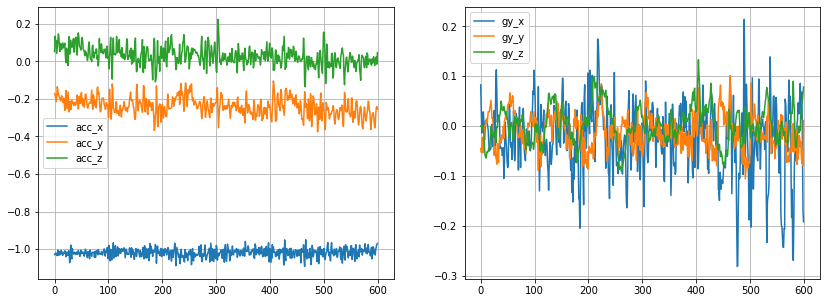

In [75]:
i = 271
print(yh[i])
show_data(train_x[i], train_y[i])

In [83]:
np.where(train_y == 12)

(array([ 283,  655,  667,  727,  731, 2193, 2266, 2347, 2360, 2540, 2639,
        2956]),)

12


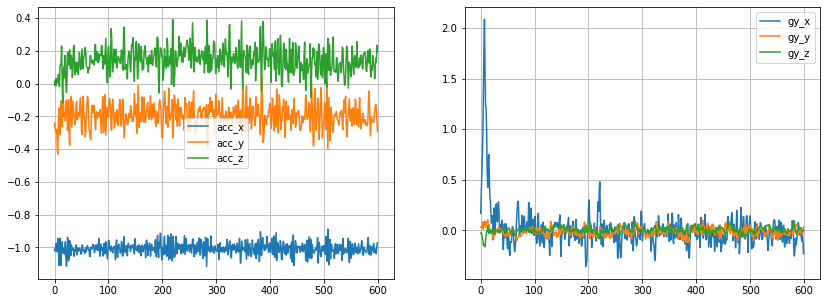

In [86]:
i = 2347
show_data(train_x[i], train_y[i])

In [87]:
df = pd.read_csv('./data/train_labels.csv')
yy = df.values[:,1:3]

In [93]:
tt = np.array(sorted(yy, key=lambda x:x[0]))

In [96]:
t1 = np.unique(tt[:,0])
t2 = np.unique(tt[:,1])
np.array(list(zip(t1,t2)))

array([['0', 'Arm Band Adjustment'],
       ['1', 'Band Pull-Down Row'],
       ['2', 'Bicep Curl'],
       ['3', 'Biceps Curl (band)'],
       ['4', 'Burpee'],
       ['5', 'Butterfly Sit-up'],
       ['6', 'Chest Press (rack)'],
       ['7', 'Crunch'],
       ['8', 'Device on Table'],
       ['9', 'Dip'],
       ['10', 'Dumbbell Deadlift Row'],
       ['11', 'Dumbbell Row (knee on bench) (label spans both arms)'],
       ['12', 'Dumbbell Row (knee on bench) (left arm)'],
       ['13', 'Dumbbell Row (knee on bench) (right arm)'],
       ['14', 'Dumbbell Squat (hands at side)'],
       ['15', 'Dynamic Stretch (at your own pace)'],
       ['16', 'Elliptical machine'],
       ['17', 'Fast Alternating Punches'],
       ['18', 'Jump Rope'],
       ['19', 'Jumping Jacks'],
       ['20', 'Kettlebell Swing'],
       ['21', 'Lateral Raise'],
       ['22', 'Lawnmower (left arm)'],
       ['23', 'Lawnmower (right arm)'],
       ['24', 'Lunge (alternating both legs, weight optional)'],
       ['2